# About this Notebook
---
This notebook is derived from the notebook series by Y. Nakama:
- Preprocessing Notebook: https://www.kaggle.com/yasufuminakama/inchi-preprocess-2
- Training Notebook: https://www.kaggle.com/yasufuminakama/inchi-resnet-lstm-with-attention-starter
- Inference Notebook: https://www.kaggle.com/yasufuminakama/inchi-resnet-lstm-with-attention-inference

The major approach involves:
- PyTorch Resnet + LSTM with Attention
- Basic image transformations
- Tokenize by characters and numbers
- Rotate test images upright to follow train set orientation

The original notebook gets a score of about 20 with 2 epochs of training. I aim to add/test a bunch of improvements over time, including:
- [x] Refactor and simplify
- [ ] Try JIT to speed things up
- [ ] Convert code to pytorch lightning
- [ ] Add wandb logging
- [ ] Half point precision training
- [ ] Try pytorch lightning XLA for TPU training
- [ ] Use EfficientNet80 with the additional of a FC layer
- [ ] Replace LSTM-Attention based model to an image captioning transformer
- [ ] Better preprocesssing (ie add precise crop, better normalization, better augmentations)
- [ ] Larger model, train for more epochs
- [ ] Play around with different tokenization methods

## References
- https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning
- https://github.com/dacon-ai/LG_SMILES_3rd
- https://www.kaggle.com/kaushal2896/bms-mt-show-attend-and-tell-pytorch-baseline

## Change Log
* reran the notebooks to reproduce the results
* combined notebooks all into one file
* refactor code to include imports, common util functions, CFG, model code, tokenizer class, config, and common variables at the very top so they aren't repeated
    * modified the logger function
    * changed path related functions to use os.path.join and changed file/dir locations to either come from and input dir or be written to an output dir
    * TestDataset was not the same between inference and training, so the training TestDataset class was renamed to ValidDataset
    * converted all print statements to logger.info
    * after these modifications, the train losses were one-to-one the same up to step 1000, and the pipeline works under test mode so we should be good

# Config
---

In [1]:
class CFG:
    debug = False
    max_len = 275
    print_freq = 250
    num_workers = 4
    model_name = "resnet34"
    size = 224
    scheduler = "CosineAnnealingLR"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs = 1  # not to exceed 9h
    # factor=0.2 # ReduceLROnPlateau
    # patience=4 # ReduceLROnPlateau
    # eps=1e-6 # ReduceLROnPlateau
    T_max = 4  # CosineAnnealingLR
    # T_0=4 # CosineAnnealingWarmRestarts
    encoder_lr = 1e-4
    decoder_lr = 4e-4
    min_lr = 1e-6
    batch_size = 64
    weight_decay = 1e-6
    gradient_accumulation_steps = 1
    max_grad_norm = 5
    attention_dim = 256
    embed_dim = 256
    decoder_dim = 512
    dropout = 0.5
    seed = 42
    n_fold = 5
    trn_fold = [0]  # [0, 1, 2, 3, 4]
    train = True

# Setup
---

## Imports

In [2]:
import os
import gc
import re
import sys
import math
import time
import random
import logging

import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import Levenshtein
from sklearn.model_selection import StratifiedKFold

import cv2

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import Compose, Normalize, Resize, Transpose, VerticalFlip
from albumentations.pytorch import ToTensorV2

import timm

# import warnings 
# warnings.filterwarnings('ignore')

## Utils

In [3]:
def get_data_paths(data_dir):
    train_dir = os.path.join(data_dir, "train")
    test_dir = os.path.join(data_dir, "test")
    train_file = os.path.join(data_dir, "train_labels.csv")
    test_file = os.path.join(data_dir, "sample_submission.csv")
    return train_dir, test_dir, train_file, test_file


def path_from_image_id(image_id, image_dir):
    return os.path.join(
        image_dir, image_id[0], image_id[1], image_id[2], image_id + ".png"
    )


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ["PYTHONHASHSEED"] = str(seed)


def get_logger(log_name, log_file=None, use_tqdm_handler=True):
    formatter = logging.Formatter("[%(asctime)s] %(levelname)s:%(name)s: %(message)s")

    sh = logging.StreamHandler()
    sh.setLevel(logging.INFO)
    sh.setFormatter(formatter)

    logger = logging.getLogger(log_name)
    logger.setLevel(logging.INFO)
    logger.addHandler(sh)

    if log_file:
        fh = logging.FileHandler(log_file)
        fh.setLevel(logging.INFO)
        fh.setFormatter(formatter)
        logger.addHandler(fh)

    return logger


def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        score = Levenshtein.distance(true, pred)
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score

## Tokenizer

In [4]:
class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text.split(' '))
        vocab = sorted(vocab)
        vocab.append('<sos>')
        vocab.append('<eos>')
        vocab.append('<pad>')
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text_to_sequence(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return sequences

    def sequence_to_text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.sequence_to_text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

## Dataset

In [5]:
class TrainDataset(Dataset):
    def __init__(self, df, tokenizer, transform=None):
        super().__init__()
        self.df = df
        self.tokenizer = tokenizer
        self.file_paths = df['file_path'].values
        self.labels = df['InChI_text'].values
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = self.labels[idx]
        label = self.tokenizer.text_to_sequence(label)
        label_length = len(label)
        label_length = torch.LongTensor([label_length])
        return image, torch.LongTensor(label), label_length
    

class ValidDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df = df
        self.file_paths = df['file_path'].values
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df = df
        self.file_paths = df["file_path"].values
        self.transform = transform
        self.fix_transform = Compose([Transpose(p=1), VerticalFlip(p=1)])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        h, w, _ = image.shape
        if h > w:
            image = self.fix_transform(image=image)["image"]
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

    
def bms_collate(batch):
    imgs, labels, label_lengths = [], [], []
    for data_point in batch:
        imgs.append(data_point[0])
        labels.append(data_point[1])
        label_lengths.append(data_point[2])
    labels = pad_sequence(labels, batch_first=True, padding_value=tokenizer.stoi["<pad>"])
    return torch.stack(imgs), labels, torch.stack(label_lengths).reshape(-1, 1)

In [6]:
def get_transforms(*, data):
    if data == "train":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )
    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

## Model

In [7]:
class Encoder(nn.Module):
    def __init__(self, model_name="resnet18", pretrained=False):
        super().__init__()
        self.cnn = timm.create_model(model_name, pretrained=pretrained)
        self.n_features = self.cnn.fc.in_features
        self.cnn.global_pool = nn.Identity()
        self.cnn.fc = nn.Identity()

    def forward(self, x):
        bs = x.size(0)
        features = self.cnn(x)
        features = features.permute(0, 2, 3, 1)
        return features


class Attention(nn.Module):
    """
    Attention network for calculate attention value
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: input size of encoder network
        :param decoder_dim: input size of decoder network
        :param attention_dim: input size of attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(
            encoder_dim, attention_dim
        )  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(
            decoder_dim, attention_dim
        )  # linear layer to transform decoder's output
        self.full_att = nn.Linear(
            attention_dim, 1
        )  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(
            2
        )  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(
            dim=1
        )  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):
    """
    Decoder network with attention network used for training
    """

    def __init__(
        self,
        attention_dim,
        embed_dim,
        decoder_dim,
        vocab_size,
        device,
        encoder_dim=512,
        dropout=0.5,
    ):
        """
        :param attention_dim: input size of attention network
        :param embed_dim: input size of embedding network
        :param decoder_dim: input size of decoder network
        :param vocab_size: total number of characters used in training
        :param encoder_dim: input size of encoder network
        :param dropout: dropout rate
        """
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.device = device
        self.attention = Attention(
            encoder_dim, decoder_dim, attention_dim
        )  # attention network
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(
            embed_dim + encoder_dim, decoder_dim, bias=True
        )  # decoding LSTMCell
        self.init_h = nn.Linear(
            encoder_dim, decoder_dim
        )  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(
            encoder_dim, decoder_dim
        )  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(
            decoder_dim, encoder_dim
        )  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(
            decoder_dim, vocab_size
        )  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        :param encoder_out: output of encoder network
        :param encoded_captions: transformed sequence from character to integer
        :param caption_lengths: length of transformed sequence
        """
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        encoder_out = encoder_out.view(
            batch_size, -1, encoder_dim
        )  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(
            dim=0, descending=True
        )
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        # embedding transformed sequence for vector
        embeddings = self.embedding(
            encoded_captions
        )  # (batch_size, max_caption_length, embed_dim)
        # initialize hidden state and cell state of LSTM cell
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        # set decode length by caption length - 1 because of omitting start token
        decode_lengths = (caption_lengths - 1).tolist()
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(
            self.device
        )
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(
            self.device
        )
        # predict sequence
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(
                encoder_out[:batch_size_t], h[:batch_size_t]
            )
            gate = self.sigmoid(
                self.f_beta(h[:batch_size_t])
            )  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat(
                    [embeddings[:batch_size_t, t, :], attention_weighted_encoding],
                    dim=1,
                ),
                (h[:batch_size_t], c[:batch_size_t]),
            )  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

    def predict(self, encoder_out, decode_lengths, tokenizer):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        encoder_out = encoder_out.view(
            batch_size, -1, encoder_dim
        )  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        # embed start tocken for LSTM input
        start_tockens = (
            torch.ones(batch_size, dtype=torch.long).to(self.device)
            * tokenizer.stoi["<sos>"]
        )
        embeddings = self.embedding(start_tockens)
        # initialize hidden state and cell state of LSTM cell
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        predictions = torch.zeros(batch_size, decode_lengths, vocab_size).to(
            self.device
        )
        # predict sequence
        for t in range(decode_lengths):
            attention_weighted_encoding, alpha = self.attention(encoder_out, h)
            gate = self.sigmoid(
                self.f_beta(h)
            )  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c)
            )  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            if np.argmax(preds.detach().cpu().numpy()) == tokenizer.stoi["<eos>"]:
                break
            embeddings = self.embedding(torch.argmax(preds, -1))
        return predictions

## Run Setup

In [8]:
set_seed(CFG.seed)
INPUT_DIR = "../input/bms-molecular-translation"
OUTPUT_DIR = "models/resnet_attention_baseline_refactor"
TRAIN_DIR, TEST_DIR, TRAIN_FILE, TEST_FILE = get_data_paths(INPUT_DIR)
os.makedirs(OUTPUT_DIR)

In [9]:
LOGGER = get_logger(__name__, os.path.join(OUTPUT_DIR, "run.log"))
device = get_device()

# Preprocess
---

In [10]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(TRAIN_FILE)
LOGGER.info(f'train.shape: {train.shape}')

[2021-04-07 16:08:57,153] INFO:__main__: train.shape: (2424186, 2)


In [11]:
# ====================================================
# Preprocess functions
# ====================================================
def split_form(form):
    string = ""
    for i in re.findall(r"[A-Z][^A-Z]*", form):
        elem = re.match(r"\D+", i).group()
        num = i.replace(elem, "")
        if num == "":
            string += f"{elem} "
        else:
            string += f"{elem} {str(num)} "
    return string.rstrip(" ")


def split_form2(form):
    string = ""
    for i in re.findall(r"[a-z][^a-z]*", form):
        elem = i[0]
        num = i.replace(elem, "").replace("/", "")
        num_string = ""
        for j in re.findall(r"[0-9]+[^0-9]*", num):
            num_list = list(re.findall(r"\d+", j))
            assert len(num_list) == 1, f"len(num_list) != 1"
            _num = num_list[0]
            if j == _num:
                num_string += f"{_num} "
            else:
                extra = j.replace(_num, "")
                num_string += f"{_num} {' '.join(list(extra))} "
        string += f"/{elem} {num_string}"
    return string.rstrip(" ")

In [12]:
# ====================================================
# preprocess train.csv
# ====================================================
train['InChI_1'] = train['InChI'].progress_apply(lambda x: x.split('/')[1])
train['InChI_text'] = train['InChI_1'].progress_apply(split_form) + ' ' + \
                    train['InChI'].apply(lambda x: '/'.join(x.split('/')[2:])).progress_apply(split_form2).values
# ====================================================
# create tokenizer
# ====================================================
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['InChI_text'].values)
torch.save(tokenizer, os.path.join(OUTPUT_DIR, 'tokenizer2.pth'))
LOGGER.info('Saved tokenizer')
# ====================================================
# preprocess train.csv
# ====================================================
lengths = []
tk0 = tqdm(train['InChI_text'].values, total=len(train))
for text in tk0:
    seq = tokenizer.text_to_sequence(text)
    length = len(seq) - 2
    lengths.append(length)
train['InChI_length'] = lengths
train.to_pickle(os.path.join(OUTPUT_DIR, 'train2.pkl'))
LOGGER.info('Saved preprocessed to ' + os.path.join(OUTPUT_DIR, "train2.pkl"))

100%|██████████| 2424186/2424186 [02:37<00:00, 15386.84it/s]
[2021-04-07 16:12:08,434] INFO:__main__: Saved tokenizer
100%|██████████| 2424186/2424186 [00:24<00:00, 99888.73it/s] 
[2021-04-07 16:12:35,966] INFO:__main__: Saved preprocessed to models/resnet_attention_baseline_refactor/train2.pkl


# Train
---

## Data Loading

In [13]:
train = pd.read_pickle(os.path.join(OUTPUT_DIR, 'train2.pkl'))
train['file_path'] = train['image_id'].apply(lambda x: path_from_image_id(x, TRAIN_DIR))

LOGGER.info(f'train.shape: {train.shape}')
display(train.head())

[2021-04-07 16:12:42,642] INFO:__main__: train.shape: (2424186, 6)


,image_id,InChI,InChI_1,InChI_text,InChI_length,file_path
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,C13H20OS,C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 -...,59,../input/bms-molecular-translation/train/0/0/0...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,C21H30O4,C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8...,108,../input/bms-molecular-translation/train/0/0/0...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,C24H23N5O4,C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 ...,112,../input/bms-molecular-translation/train/0/0/0...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,C17H24N2O4S,C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 (...,108,../input/bms-molecular-translation/train/0/0/0...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,C10H19N3O2S,C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 -...,72,../input/bms-molecular-translation/train/0/0/0...


In [14]:
tokenizer = torch.load(os.path.join(OUTPUT_DIR, 'tokenizer2.pth'))
LOGGER.info(f"tokenizer.stoi: {tokenizer.stoi}")

[2021-04-07 16:12:42,679] INFO:__main__: tokenizer.stoi: {'(': 0, ')': 1, '+': 2, ',': 3, '-': 4, '/b': 5, '/c': 6, '/h': 7, '/i': 8, '/m': 9, '/s': 10, '/t': 11, '0': 12, '1': 13, '10': 14, '100': 15, '101': 16, '102': 17, '103': 18, '104': 19, '105': 20, '106': 21, '107': 22, '108': 23, '109': 24, '11': 25, '110': 26, '111': 27, '112': 28, '113': 29, '114': 30, '115': 31, '116': 32, '117': 33, '118': 34, '119': 35, '12': 36, '120': 37, '121': 38, '122': 39, '123': 40, '124': 41, '125': 42, '126': 43, '127': 44, '128': 45, '129': 46, '13': 47, '130': 48, '131': 49, '132': 50, '133': 51, '134': 52, '135': 53, '136': 54, '137': 55, '138': 56, '139': 57, '14': 58, '140': 59, '141': 60, '142': 61, '143': 62, '144': 63, '145': 64, '146': 65, '147': 66, '148': 67, '149': 68, '15': 69, '150': 70, '151': 71, '152': 72, '153': 73, '154': 74, '155': 75, '156': 76, '157': 77, '158': 78, '159': 79, '16': 80, '161': 81, '163': 82, '165': 83, '167': 84, '17': 85, '18': 86, '19': 87, '2': 88, '20': 

In [15]:
train['InChI_length'].max()

275

In [16]:
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

## CV split

In [17]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds['InChI_length'])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
LOGGER.info(folds.groupby(['fold']).size())

/home/jay/.pyenv/versions/3.8.7/envs/base/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[2021-04-07 16:12:44,220] INFO:__main__: fold
0    484838
1    484837
2    484837
3    484837
4    484837
dtype: int64


## Transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


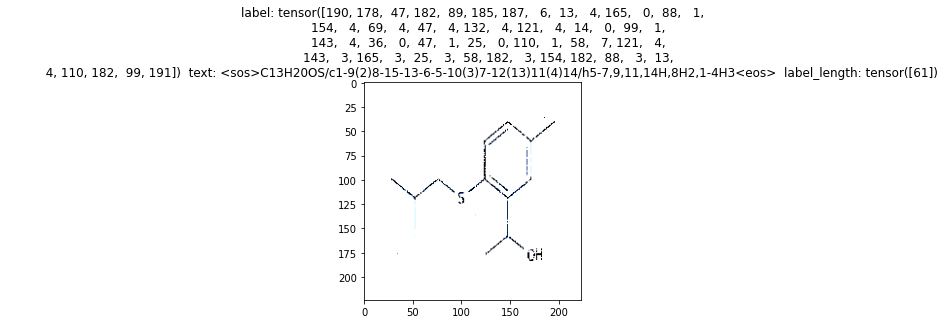

In [18]:
from matplotlib import pyplot as plt

train_dataset = TrainDataset(train, tokenizer, transform=get_transforms(data='train'))

for i in range(1):
    image, label, label_length = train_dataset[i]
    text = tokenizer.sequence_to_text(label.numpy())
    plt.imshow(image.transpose(0, 1).transpose(1, 2))
    plt.title(f'label: {label}  text: {text}  label_length: {label_length}')
    plt.show() 

## Helper functions

In [19]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, encoder, decoder, criterion, 
             encoder_optimizer, decoder_optimizer, epoch,
             encoder_scheduler, decoder_scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    # switch to train mode
    encoder.train()
    decoder.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels, label_lengths) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)
        batch_size = images.size(0)
        features = encoder(images)
        predictions, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, labels, label_lengths)
        targets = caps_sorted[:, 1:]
        predictions = pack_padded_sequence(predictions, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        loss = criterion(predictions, targets)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        loss.backward()
        encoder_grad_norm = torch.nn.utils.clip_grad_norm_(encoder.parameters(), CFG.max_grad_norm)
        decoder_grad_norm = torch.nn.utils.clip_grad_norm_(decoder.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            encoder_optimizer.step()
            decoder_optimizer.step()
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            LOGGER.info('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Encoder Grad: {encoder_grad_norm:.4f}  '
                  'Decoder Grad: {decoder_grad_norm:.4f}  '
                  #'Encoder LR: {encoder_lr:.6f}  '
                  #'Decoder LR: {decoder_lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   encoder_grad_norm=encoder_grad_norm,
                   decoder_grad_norm=decoder_grad_norm,
                   #encoder_lr=encoder_scheduler.get_lr()[0],
                   #decoder_lr=decoder_scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, encoder, decoder, tokenizer, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    # switch to evaluation mode
    encoder.eval()
    decoder.eval()
    text_preds = []
    start = end = time.time()
    for step, (images) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        batch_size = images.size(0)
        with torch.no_grad():
            features = encoder(images)
            predictions = decoder.predict(features, CFG.max_len, tokenizer)
        predicted_sequence = torch.argmax(predictions.detach().cpu(), -1).numpy()
        _text_preds = tokenizer.predict_captions(predicted_sequence)
        text_preds.append(_text_preds)
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            LOGGER.info('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    text_preds = np.concatenate(text_preds)
    return text_preds

## Train loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds['InChI'].values

    train_dataset = TrainDataset(train_folds, tokenizer, transform=get_transforms(data='train'))
    valid_dataset = ValidDataset(valid_folds, transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, 
                              pin_memory=True,
                              drop_last=True, 
                              collate_fn=bms_collate)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers,
                              pin_memory=True, 
                              drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    encoder = Encoder(CFG.model_name, pretrained=True)
    encoder.to(device)
    encoder_optimizer = Adam(encoder.parameters(), lr=CFG.encoder_lr, weight_decay=CFG.weight_decay, amsgrad=False)
    encoder_scheduler = get_scheduler(encoder_optimizer)
    
    decoder = DecoderWithAttention(attention_dim=CFG.attention_dim,
                                   embed_dim=CFG.embed_dim,
                                   decoder_dim=CFG.decoder_dim,
                                   vocab_size=len(tokenizer),
                                   dropout=CFG.dropout,
                                   device=device)
    decoder.to(device)
    decoder_optimizer = Adam(decoder.parameters(), lr=CFG.decoder_lr, weight_decay=CFG.weight_decay, amsgrad=False)
    decoder_scheduler = get_scheduler(decoder_optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.stoi["<pad>"])

    best_score = np.inf
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, encoder, decoder, criterion, 
                            encoder_optimizer, decoder_optimizer, epoch, 
                            encoder_scheduler, decoder_scheduler, device)

        # eval
        text_preds = valid_fn(valid_loader, encoder, decoder, tokenizer, criterion, device)
        text_preds = [f"InChI=1S/{text}" for text in text_preds]
        LOGGER.info(f"labels: {valid_labels[:5]}")
        LOGGER.info(f"preds: {text_preds[:5]}")
        
        # scoring
        score = get_score(valid_labels, text_preds)
        
        if isinstance(encoder_scheduler, ReduceLROnPlateau):
            encoder_scheduler.step(score)
        elif isinstance(encoder_scheduler, CosineAnnealingLR):
            encoder_scheduler.step()
        elif isinstance(encoder_scheduler, CosineAnnealingWarmRestarts):
            encoder_scheduler.step()
            
        if isinstance(decoder_scheduler, ReduceLROnPlateau):
            decoder_scheduler.step(score)
        elif isinstance(decoder_scheduler, CosineAnnealingLR):
            decoder_scheduler.step()
        elif isinstance(decoder_scheduler, CosineAnnealingWarmRestarts):
            decoder_scheduler.step()

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'encoder': encoder.state_dict(), 
                        'encoder_optimizer': encoder_optimizer.state_dict(), 
                        'encoder_scheduler': encoder_scheduler.state_dict(), 
                        'decoder': decoder.state_dict(), 
                        'decoder_optimizer': decoder_optimizer.state_dict(), 
                        'decoder_scheduler': decoder_scheduler.state_dict(), 
                        'text_preds': text_preds,
                       },
                        os.path.join(OUTPUT_DIR, f"model_{fold}.pth"))

## Main

In [22]:
if CFG.train:
    # train
    oof_df = pd.DataFrame()
    for fold in range(CFG.n_fold):
        if fold in CFG.trn_fold:
            train_loop(folds, fold)

[2021-04-07 16:31:36,699] INFO:__main__: ========== fold: 0 training ==========
[2021-04-07 16:32:22,268] INFO:__main__: Epoch: [1][0/30302] Data 8.818 (8.818) Elapsed 0m 23s (remain 11953m 18s) Loss: 5.2983(5.2983) Encoder Grad: 1.1685  Decoder Grad: 1.1643  
[2021-04-07 16:36:37,081] INFO:__main__: Epoch: [1][250/30302] Data 0.000 (0.654) Elapsed 4m 38s (remain 555m 41s) Loss: 1.7251(2.3154) Encoder Grad: 0.2304  Decoder Grad: 0.5294  
[2021-04-07 16:39:46,356] INFO:__main__: Epoch: [1][500/30302] Data 0.000 (0.505) Elapsed 7m 47s (remain 463m 43s) Loss: 1.4780(1.9542) Encoder Grad: 0.2628  Decoder Grad: 0.4859  
[2021-04-07 16:42:54,926] INFO:__main__: Epoch: [1][750/30302] Data 0.413 (0.453) Elapsed 10m 56s (remain 430m 25s) Loss: 1.4284(1.7858) Encoder Grad: 0.4203  Decoder Grad: 0.9050  
[2021-04-07 16:45:48,122] INFO:__main__: Epoch: [1][1000/30302] Data 0.263 (0.412) Elapsed 13m 49s (remain 404m 41s) Loss: 1.2526(1.6714) Encoder Grad: 0.3239  Decoder Grad: 1.0006  


KeyboardInterrupt: 

# Inference
---

os.path.join(INPUT_DIR, TEST_FILE))## Data Loading

In [31]:
test = pd.read_csv(TEST_FILE)
test['file_path'] = test['image_id'].apply(lambda x: path_from_image_id(x, TEST_DIR))

LOGGER.info(f'test.shape: {test.shape}')
display(test.head())

[2021-04-07 03:49:42,839] INFO:__main__: test.shape: (1616107, 3)


,image_id,InChI,file_path
0,00000d2a601c,InChI=1S/H2O/h1H2,../input/bms-molecular-translation/test/0/0/0/...
1,00001f7fc849,InChI=1S/H2O/h1H2,../input/bms-molecular-translation/test/0/0/0/...
2,000037687605,InChI=1S/H2O/h1H2,../input/bms-molecular-translation/test/0/0/0/...
3,00004b6d55b6,InChI=1S/H2O/h1H2,../input/bms-molecular-translation/test/0/0/0/...
4,00004df0fe53,InChI=1S/H2O/h1H2,../input/bms-molecular-translation/test/0/0/0/...


In [32]:
tokenizer = torch.load(os.path.join(OUTPUT_DIR, 'tokenizer2.pth'))
LOGGER.info(f"tokenizer.stoi: {tokenizer.stoi}")

[2021-04-07 03:49:42,847] INFO:__main__: tokenizer.stoi: {'(': 0, ')': 1, '+': 2, ',': 3, '-': 4, '/b': 5, '/c': 6, '/h': 7, '/i': 8, '/m': 9, '/s': 10, '/t': 11, '0': 12, '1': 13, '10': 14, '100': 15, '101': 16, '102': 17, '103': 18, '104': 19, '105': 20, '106': 21, '107': 22, '108': 23, '109': 24, '11': 25, '110': 26, '111': 27, '112': 28, '113': 29, '114': 30, '115': 31, '116': 32, '117': 33, '118': 34, '119': 35, '12': 36, '120': 37, '121': 38, '122': 39, '123': 40, '124': 41, '125': 42, '126': 43, '127': 44, '128': 45, '129': 46, '13': 47, '130': 48, '131': 49, '132': 50, '133': 51, '134': 52, '135': 53, '136': 54, '137': 55, '138': 56, '139': 57, '14': 58, '140': 59, '141': 60, '142': 61, '143': 62, '144': 63, '145': 64, '146': 65, '147': 66, '148': 67, '149': 68, '15': 69, '150': 70, '151': 71, '152': 72, '153': 73, '154': 74, '155': 75, '156': 76, '157': 77, '158': 78, '159': 79, '16': 80, '161': 81, '163': 82, '165': 83, '167': 84, '17': 85, '18': 86, '19': 87, '2': 88, '20': 

In [33]:
if CFG.debug:
    test = test.head(1000)

## Dataset

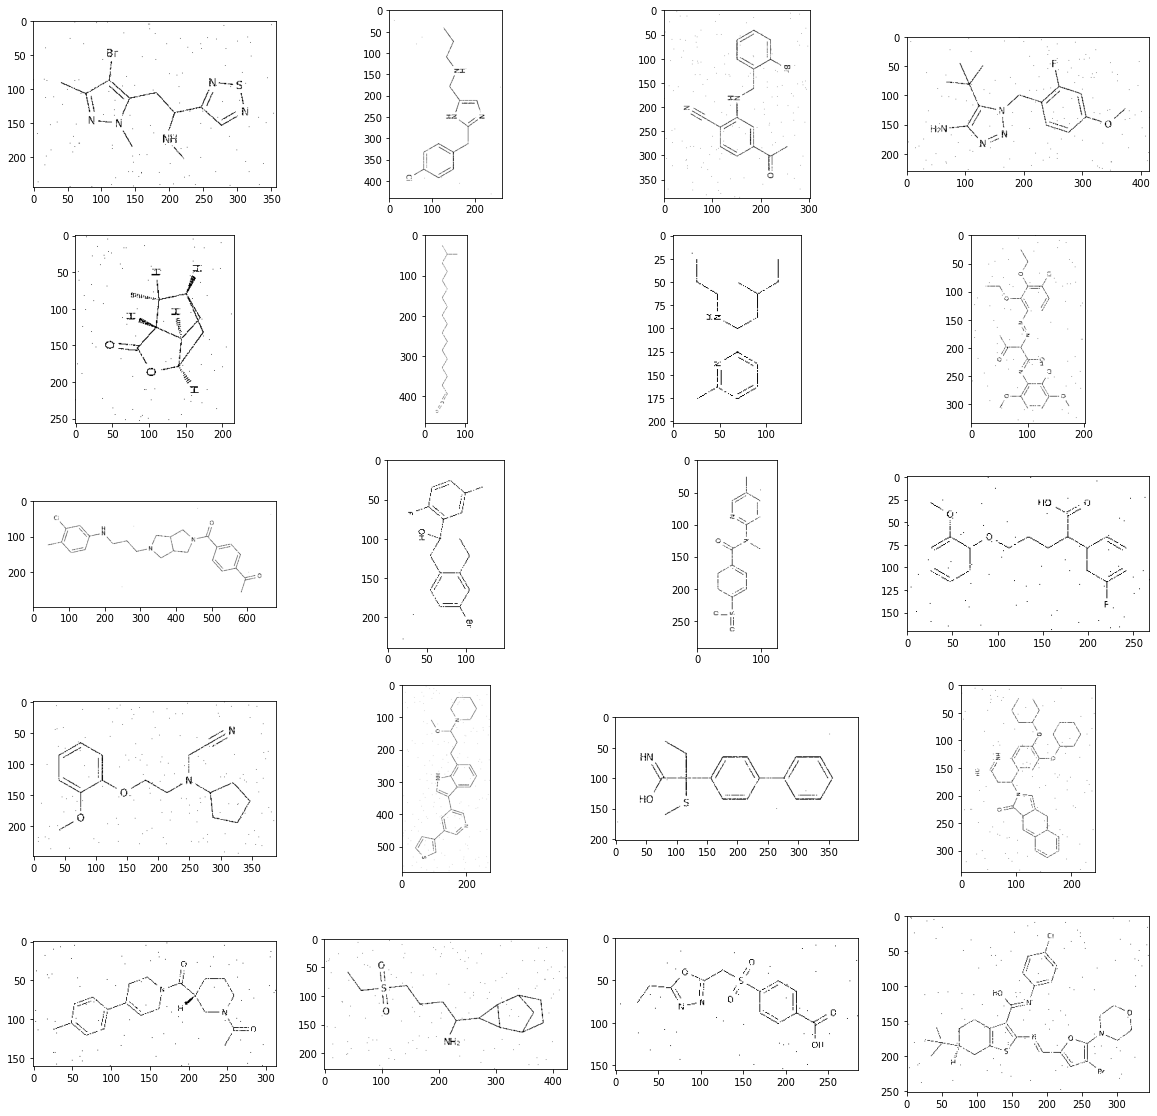

In [34]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 20))
for i in range(20):
    image = cv2.imread(test.loc[i, 'file_path'])
    plt.subplot(5, 4, i + 1)
    plt.imshow(image)
plt.show()

- There are 90° rotated images, but we trained horizontal compounds images, so we need to fix them

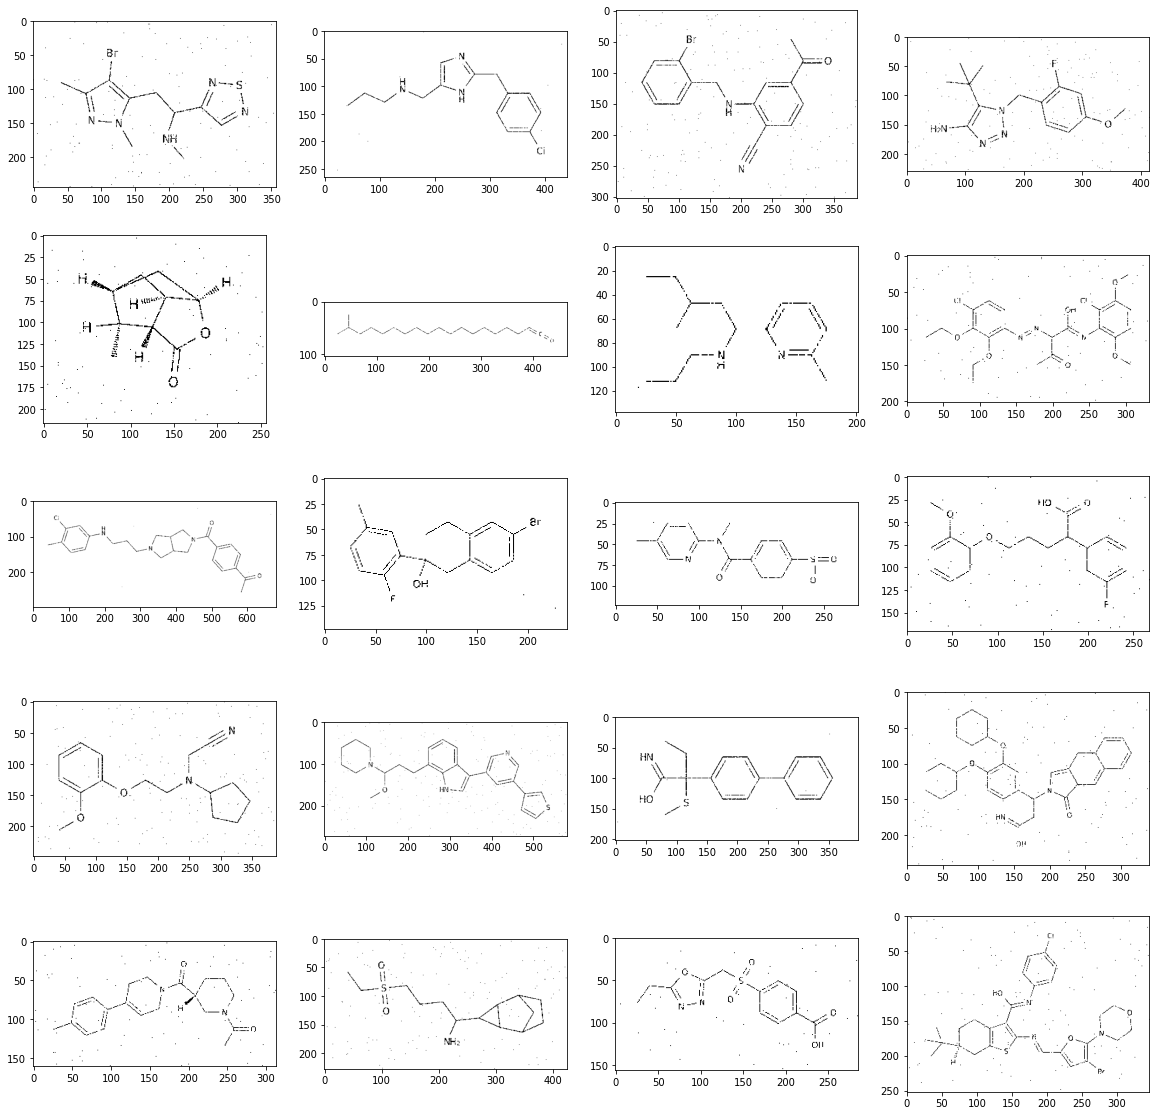

In [35]:
from matplotlib import pyplot as plt

transform = Compose([Transpose(p=1), VerticalFlip(p=1)])

plt.figure(figsize=(20, 20))
for i in range(20):
    image = cv2.imread(test.loc[i, 'file_path'])
    h, w, _ = image.shape
    if h > w:
        image = transform(image=image)['image']
    plt.subplot(5, 4, i + 1)
    plt.imshow(image)
plt.show()

## Inference

In [37]:
def inference(test_loader, encoder, decoder, tokenizer, device):
    encoder.eval()
    decoder.eval()
    text_preds = []
    tk0 = tqdm(test_loader, total=len(test_loader))
    for images in tk0:
        images = images.to(device)
        with torch.no_grad():
            features = encoder(images)
            predictions = decoder.predict(features, CFG.max_len, tokenizer)
        predicted_sequence = torch.argmax(predictions.detach().cpu(), -1).numpy()
        _text_preds = tokenizer.predict_captions(predicted_sequence)
        text_preds.append(_text_preds)
    text_preds = np.concatenate(text_preds)
    return text_preds

In [38]:
states = torch.load(os.path.join(OUTPUT_DIR, "model_0.pth"), map_location=torch.device('cpu'))

encoder = Encoder(CFG.model_name, pretrained=False)
encoder.load_state_dict(states['encoder'])
encoder.to(device)

decoder = DecoderWithAttention(attention_dim=CFG.attention_dim,
                               embed_dim=CFG.embed_dim,
                               decoder_dim=CFG.decoder_dim,
                               vocab_size=len(tokenizer),
                               dropout=CFG.dropout,
                               device=device)
decoder.load_state_dict(states['decoder'])
decoder.to(device)

del states; gc.collect()

test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=CFG.num_workers)
predictions = inference(test_loader, encoder, decoder, tokenizer, device)

del test_loader, encoder, decoder, tokenizer; gc.collect()

100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


32

In [39]:
# submission
test['InChI'] = [f"InChI=1S/{text}" for text in predictions]
test[['image_id', 'InChI']].to_csv(os.path.join(OUTPUT_DIR, 'submission.csv'), index=False)
test[['image_id', 'InChI']].head()

,image_id,InChI
0,00000d2a601c,InChI=1S/C18HNNOO/c1-2-10-10-11-11-15(18)19-15...
1,00001f7fc849,InChI=1S/C15H19N2O2/c1-2-3-8-8-11-11-11-11-11-...
2,000037687605,InChI=1S/C18H20N2O2/c1-2-3-10-10-11-10-11-11-1...
3,00004b6d55b6,InChI=1S/C18HNNOO/c1-2-3-7-10-11-15(18)19-15-1...
4,00004df0fe53,InChI=1S/C15HNNO/c1-2-8-10-8-7-8-10-7-8-7-7-8-...
